# Install Dependencies

In [ ]:
!pip3 install --upgrade pip
!pip3 install micrograd
!pip3 install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 tqdm==4.66.6
!pip3 install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 53.9 

# Introduction to Automatic gradients.

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

xs = np.arange(-5, 5, 0.25)
ys = f(xs)

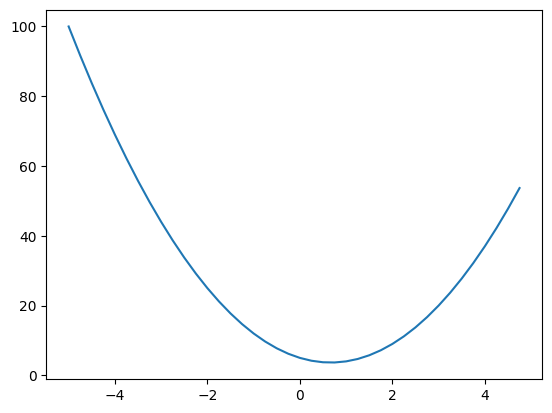

In [ ]:
plt.plot(xs, ys)

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='') -> None:
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    return Value(self.data + other.data, (self, other), '+')

  def __sub__(self, other):
    return Value(self.data - other.data, (self, other), '-')

  def __mul__(self, other):
    return Value(self.data * other.data, (self, other), '*')

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

In [ ]:
import torch
from torch import tensor

x1 = tensor(2.0, requires_grad=True)
x2 = tensor(0.0, requires_grad=True)
w1 = tensor(-3.0, requires_grad=True)
w2 = tensor(1.0, requires_grad=True)
b = tensor(6.88, requires_grad=True)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)


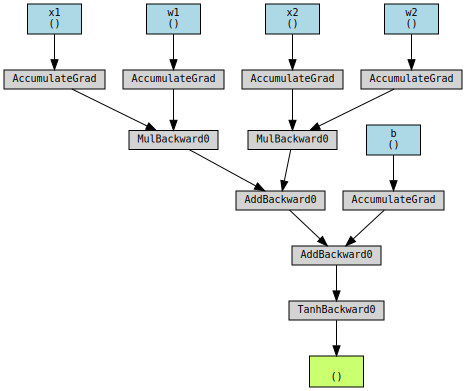

In [ ]:
from torchviz import make_dot

dot = make_dot(o, params={"x1": x1, "x2": x2, "w1": w1, "w2": w2, "b": b  })
dot.render("tensor_graph", format="png")  # Saves graph as PNG
dot  # Displays in a Jupyter notebook (if running interactively)

In [ ]:
from graphviz import Digraph
from torchviz import make_dot


def bfs_trace(root):
  nodes, edges = set([root]), set()
  curr_nodes, new_nodes = set([root]), set()

  while len(curr_nodes):
    for node in curr_nodes:
      for child in node._prev:
        if child not in nodes:
          new_nodes.add(child)
          nodes.add(child)
          edges.add((child, node))
    curr_nodes.clear()
    curr_nodes.update(new_nodes)
    new_nodes.clear()

  return nodes, edges

# Character level language modeling

## Load dataset


In [ ]:
def load_names_dataset():
  all_names = []
  with open('sample_data/names.txt', 'r') as names_file:
    entries = names_file.read()
    names = entries.splitlines()
    all_names = names
  return all_names

In [ ]:
names_dataset = load_names_dataset()

In [ ]:
len(names_dataset)

32033

## Bi-gram model

In [ ]:
from collections import defaultdict
from torch import tensor, int32, zeros, multinomial, Generator

# def build_2gram(names):
#   freq = defaultdict(int)
#   for name in names:
#     chars = ['.'] + list(name) + ['.'] # Attach special start and end of name token
#     for ch1, ch2 in zip(chars, chars[1:]):
#       freq[(ch1, ch2)] += 1
#   return freq

# def build_2gram_model(names):
#   bi_grams = build_2gram(names)

#   all_chars = ['.'] + [chr(i) for i in range(97, 97 + 26)]
#   ch_idx_lookup_table = {}
#   ch_lookup_table = {}
#   for idx, ch in enumerate(all_chars):
#     ch_idx_lookup_table[ch] = idx
#     ch_lookup_table[idx] = ch

#   prob_2gram_tensor = zeros((27, 27), dtype=int32)
#   for (ch1, ch2), freq in bi_grams.items():
#     ch1_idx = ch_idx_lookup_table[ch1]
#     ch2_idx = ch_idx_lookup_table[ch2]
#     prob_2gram_tensor[ch1_idx][ch2_idx] = freq
#   row_totals = prob_2gram_tensor.sum(axis=1, keepdim=True)
#   prob_2gram_tensor = prob_2gram_tensor / row_totals

#   return prob_2gram_tensor, ch_lookup_table

class BiGramModel:
  def __init__(self, dataset) -> None:
    self.ch_idx_lookup_table = {}
    self.ch_lookup_table = {}
    self.prob_2gram_tensor = zeros((27, 27), dtype=int32)
    self._build_2gram_model(dataset)
    self.gen = Generator().manual_seed(2147483647)

  def _build_2gram(self, names):
    freq = defaultdict(int)
    for name in names:
      chars = ['.'] + list(name) + ['.'] # Attach special start and end of name token
      for ch1, ch2 in zip(chars, chars[1:]):
        freq[(ch1, ch2)] += 1
    return freq

  def _build_2gram_model(self, names):
    bi_grams = self._build_2gram(names)

    all_chars = ['.'] + [chr(i) for i in range(97, 97 + 26)]

    for idx, ch in enumerate(all_chars):
      self.ch_idx_lookup_table[ch] = idx
      self.ch_lookup_table[idx] = ch

    for (ch1, ch2), freq in bi_grams.items():
      ch1_idx = self.ch_idx_lookup_table[ch1]
      ch2_idx = self.ch_idx_lookup_table[ch2]
      self.prob_2gram_tensor[ch1_idx][ch2_idx] = freq
    self.prob_2gram_tensor += 1.0 # Model smoothing; Non inf negative log likelihood
    row_totals = self.prob_2gram_tensor.sum(axis=1, keepdim=True)
    self.prob_2gram_tensor = self.prob_2gram_tensor / row_totals

  def sample(self, max_len=25):
    max_len = max(1, max_len)
    idx = 0
    chars = [self.ch_lookup_table[idx]]
    for i in range(max_len):
      next_idx =  multinomial(self.prob_2gram_tensor[idx], num_samples=1, replacement=True, generator=self.gen).item()
      next_char = self.ch_lookup_table[next_idx]
      chars.append(next_char)
      if next_char == '.':
        break
      idx = next_idx
    if chars[-1] != '.':
      chars.append('.')

    return ''.join(chars)

In [ ]:
model = BiGramModel(names_dataset)
BG_TENSOR = model.prob_2gram_tensor

In [ ]:
model.sample()

'.juee.'

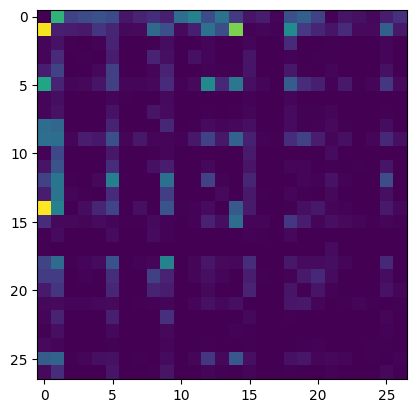

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(BG_TENSOR)

In [ ]:
x = tensor([[1,2,-1],[-1,-2,1]])
torch.sum(x, axis=1, keepdim=True)

tensor([[ 2],
        [-2]])

# [Building GPT from scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=7)